<a href="https://colab.research.google.com/github/caio-emiliano/data_science/blob/main/Housing%20Prices%20Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Competition - Análise Exploratória dos Dados e Treinamento de Modelo de Predição

In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#Iremos ler os dados dos arquivos CSVs e criar um DataFrame para estes.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
#Dimensões dos Dados:
print("DIMENSÕES DO DATAFRAME TRAIN:")
print("Linhas:\t\t{}".format(train.shape[0]))
print("Colunas:\t{}".format(train.shape[1]))
print("DIMENSÕES DO DATAFRAME TEST:")
print("Linhas:\t\t{}".format(test.shape[0]))
print("Colunas:\t{}".format(test.shape[1]))

DIMENSÕES DO DATAFRAME TRAIN:
Linhas:		1460
Colunas:	81
DIMENSÕES DO DATAFRAME TEST:
Linhas:		1459
Colunas:	80


In [ ]:
#Como o Dataframe possui 81 colunas e o máximo de linhas que o Pandas mostra é 60, não conseguimos ver os dados de todas as colunas
#ao tentarmos analisar o tipo de dados de cada coluna.
pd.get_option("display.max_rows")

#Por isso, é necessário desabilitar o limite de linhas a serem mostradas
pd.set_option('display.max_rows', None)

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Nesta análise, estamos interessados em predizer o preço de venda de uma casa em Ames, Iowa. Essa informação pode ser encontrada na coluna SalePrice do nosso DataFrame. Os dados nos quais estamos interessados são comumente chamados de 'target'. Usarei essa nomenclatura adiante para facilitar a compreensão. 

###Primeiramente é interessante plotarmos algumas informações para a análise exploratória. Portanto, começarei minha análise com a distribuição dos preços dos imóveis.

In [ ]:
#Para isso usarei a biblioteca matplotlib e a biblioteca seaborn

import matplotlib.pyplot as plt
import seaborn as sns

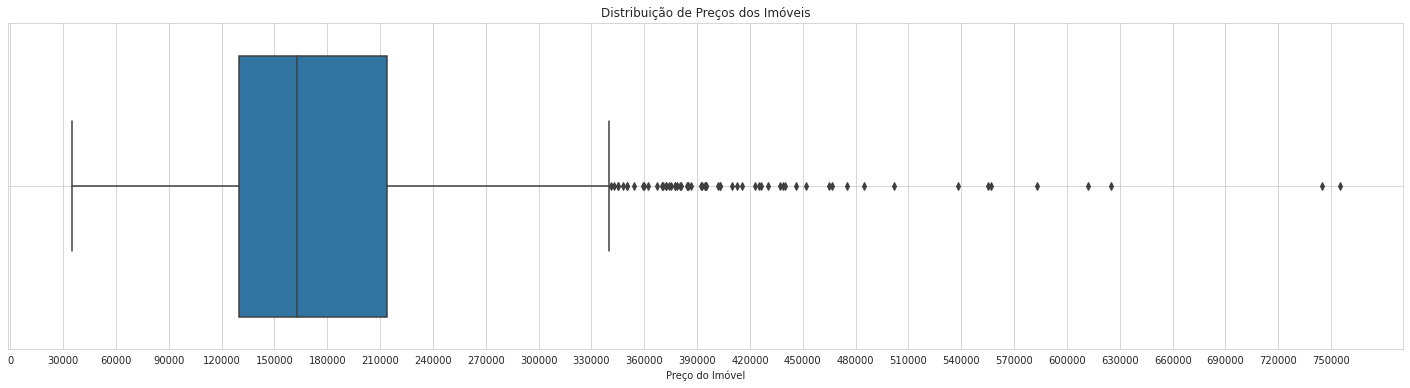

In [ ]:
sns.set_style("whitegrid") #Para carregar o estilo de gráfico desejado no Seaborn
plt.figure(figsize=(25, 6)) #Como redimensionar o tamanho da figura

ax = sns.boxplot(x='SalePrice', data=train) #Criando o gráfico boxplot

ax.set_title('Distribuição de Preços dos Imóveis') #Título do Gráfico
ax.set_xlabel("Preço do Imóvel")
ax.set_xticks(np.arange(0, 755000, 30000)) ##Step dos valores X no Gráfico
ax.grid(True)
plt.show()  

In [ ]:
#Usaremos a função Series.describe() para descobrirmos mais informações dos dados que queremos predizer (preços)

train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

####Através dados acima, podemos perceber que a média dos valores das casas é de $180.000.

####Enquanto que a faixa de valores das casas gira entorno do intervalo $130.000 - $215.000 (com exceção dos outliers)

###Outra informação importante que devemos analisar é se o Target está deslocado ao longo da distribuição de valores (em inglês skewed).

###Isto é importante pois caso os dados estejam mal distribuídos, realizar uma transformação log ajudará na performance quando fizermos a regressão.

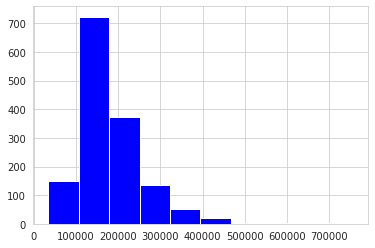

In [ ]:
plt.hist(train.SalePrice, color='blue')
plt.show()

In [ ]:
print ("Deslocamento é de:", train.SalePrice.skew())

Deslocamento é de: 1.8828757597682129


####Aqui percebemos que existe um deslocamento dos dados a direita. Quanto mais próximo de 0 o valor da função skew for, melhor uniformemente distribuido estarão os dados. Em seguida irei aplicar uma transformação log no target e reanalisarei o deslocamento

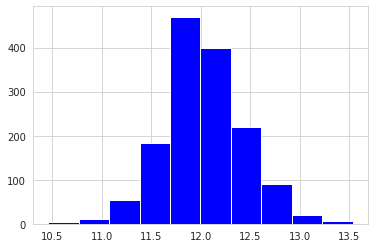

In [ ]:
target = np.log(train.SalePrice)
plt.hist(target, color='blue')
plt.show()

In [ ]:
print("Deslocamento é de:", target.skew())

Deslocamento é de: 0.12133506220520406


##Trabalhando com os Dados

###Dados Numéricos

In [ ]:
#Aqui seleciono somente as colunas numéricas do DataFrame
numeric_data = train.select_dtypes(include=[np.number])

####Já que estou analisando somente as features numéricas, uma função interessante de ser utilizada é a DataFrame.corr(). Esta função mostra a correlação entre as colunas de dados, assim podemos examinar a correlação entre as features e o target.

In [ ]:
corr = numeric_data.corr()
print(corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print(corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


Enquanto as 5 primeiras colunas apresentam uma correlação mais positiva, as últimas 5 apresentam correlação negativa. 

Irei analisar mais profundamente a coluna "OverallQual", coluna que a apresenta maior valor de correlação (em módulo) com nosso objetivo.

In [ ]:
#Qual o tipo de dado da coluna "OverallQual"?
train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

Usarei uma [Tabela Pivo](https://https://en.wikipedia.org/wiki/Pivot_table) - ou do inglês Pivot Table - para investigar melhor o relacionamento entre as colunas. Olharei para a média na análise a seguir.

In [ ]:
quality_pivot = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
print(quality_pivot)

             SalePrice
OverallQual           
1                50150
2                60000
3                86250
4               108000
5               133000
6               160000
7               200141
8               269750
9               345000
10              432390


<Figure size 1440x1080 with 0 Axes>

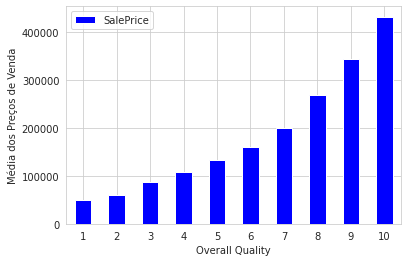

In [ ]:
plt.figure(figsize=(20, 15)) #Redimensionar o tamanho da figura

ax = quality_pivot.plot(kind='bar', color='blue')

ax.set_xlabel("Overall Quality")
ax.set_ylabel("Média dos Preços de Venda")

plt.xticks(rotation=0) #Rotaciono as labels do eixo X, pois elas estavam de lado

plt.show()

####CONCLUSÃO: Com o gráfico acima, podemos perceber que os preços aumentam a medida que o índice de qualidade geral também aumenta.

####A próxima coluna de dados que irei analisar é a "GrLivArea", que é a segunda coluna com maior índice de correlação em módulo. Irei usar o gráfico do tipo scatter para visualizar a relação entre GrLivArea e nosso target - SalePrice

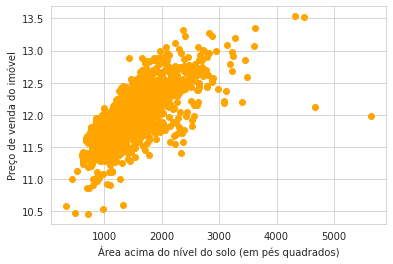

In [ ]:
plt.scatter(x=train['GrLivArea'], y=target, color='orange')
plt.xlabel("Área acima do nível do solo (em pés quadrados)")
plt.ylabel("Preço de venda do imóvel")

plt.show()

####Em seguida irei analisar a coluna de dados "GarageArea", que é a terceira coluna com maior índice de correlação em módulo. Também irei usar o gráfico do tipo scatter para visualizar a relação entre GarageArea e o SalePrice

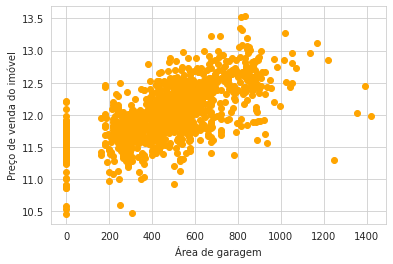

In [ ]:
plt.scatter(x=train['GarageArea'], y=target, color='orange')
plt.xlabel("Área de garagem")
plt.ylabel("Preço de venda do imóvel")

plt.show()

####Do gráfico, percebemos duas importantes informações: existem algumas casas sem garagem (representadas no gráfico pelos pontos onde y=0) e também existem [outliers](https://https://en.wikipedia.org/wiki/Outlier) - pontos que diferem significativamente dos outros observados - neste conjunto de dados.

####Irei tratar dos dados nulos futuramente. Por agora irei apenas remover alguns dos pontos que diferem do comportamento observado no gráfico. 

In [ ]:
train = train[train['GarageArea'] < 1200]

#outliers = (train['GarageArea'] == 0)
#print("Número de imóveis que não possuem garagem:", outliers.value_counts(normalize=True) )


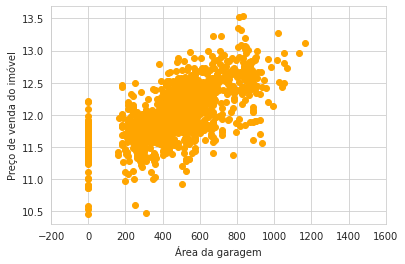

In [ ]:
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice), color='orange')

#Um detalhe importante é que se simplesmente printarmos o gráfico da forma original, não iremos conseguir perceber os pontos removidos facilmente. 
#Já que alteramos as dimensões do conjunto de dados, o gráfico é redimensionado automaticamente.
#Para "forçarmos" a escala antiga e facilitarmos a visualização, irei utilizar o comando limit abaixo.

plt.xlim(-200,1600)

plt.xlabel("Área da garagem")
plt.ylabel("Preço de venda do imóvel")

plt.show()

###Tratando os Dados Nulos

####Por agora examinaremos os dados nulos do conjunto numérico. Utilizarei a sequencia train.isnull.sum(), a qual me retornará um DataFrame com o número de valores nulos de cada feature

In [ ]:
nulls = train.isnull().sum().sort_values(ascending=False)[:25]

numIndex = nulls.index
numValues = nulls.values

nulls = pd.DataFrame(data=numValues, index=numIndex, columns=['Null Count'])

nulls.index.name = 'Feature'

print(nulls)

              Null Count
Feature                 
PoolQC              1449
MiscFeature         1402
Alley               1364
Fence               1174
FireplaceQu          689
LotFrontage          258
GarageCond            81
GarageType            81
GarageYrBlt           81
GarageFinish          81
GarageQual            81
BsmtExposure          38
BsmtFinType2          38
BsmtFinType1          37
BsmtCond              37
BsmtQual              37
MasVnrArea             8
MasVnrType             8
Electrical             1
Utilities              0
YearRemodAdd           0
MSSubClass             0
Foundation             0
ExterCond              0
ExterQual              0


####Através da documentação dos dados, entendemos que tanto para o caso da coluna 'PoolQC' quanto para as colunas relacionadas a garagem, os valores são *Nan* para o caso da área correspondente ser *0* ou então inexistente.

####Analisaremos também a coluna de dados 'MiscFeature'. 

In [ ]:
print("Os valores desta coluna são:", train.MiscFeature.unique())

Os valores desta coluna são: [nan 'Shed' 'Gar2' 'Othr' 'TenC']


####Ao olharmos a documentação dos dados, esta coluna é descrita como abaixo.

```
MiscFeature: Miscellaneous feature not covered in other categories

   Elev Elevator
   Gar2 2nd Garage (if not described in garage section)
   Othr Other
   Shed Shed (over 100 SF)
   TenC Tennis Court
   NA   None
```
####Os valores descrevem se a casa tem mais de 100 pés quadrados, se tem uma segunda garagem, se tem quadra de tênis etc. 

####Nós talvez possamos usar essas informações futuramente

###Lidando com os dados não númericos

In [ ]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1455,91,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1447,1455,1455,1455,1418,1418,1417,1418,1417,1455,1455,1455,1454,1455,1455,766,1374,1374,1374,1374,1455,6,281,53,1455,1455
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,7,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1147,1450,50,921,1309,1454,1048,1378,225,1257,1441,1216,722,1139,1430,514,503,863,905,1278,644,647,1306,951,428,1251,1423,737,1360,1329,733,1355,377,867,605,1306,1321,1335,2,157,48,1266,1196


####Na tabela, a coluna 'count' descreve a contagem de ocorrências não numéricas. 'Unique' representa o número de valores únicos. Já o 'top' são os dados que aparecem com mais frequência, sendo esta frequência apresentada na coluna 'freq'.

###Transformando os dados

####Primeiro analisarei a coluna 'Street', coluna que possui apenas 2 valores: 'Pave' e 'Grvl'. Esses valores demonstram o tipo de acesso a casa.

In [ ]:
print(train.Street.value_counts())

Pave    1450
Grvl       5
Name: Street, dtype: int64


####Nosso modelo precisa de dados numéricos. Logo, podemos transformar essas 2 informações em números. Para isso, usarei o método pd.get_dummies().

In [ ]:
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(train.Street, drop_first=True)

In [ ]:
print(train.enc_street.value_counts())

1    1450
0       5
Name: enc_street, dtype: int64


####Desta forma, transformamos variáveis categóricas em dados booleanos (os quais servem para nosso futuro modelo). Farei uma análise semelhante com a coluna 'SaleCondition', através de tabela pivot,

<Figure size 720x576 with 0 Axes>

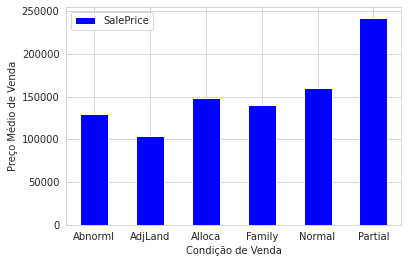

In [ ]:
plt.figure(figsize=(10, 8))

condition_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')

plt.xlabel('Condição de Venda')
plt.ylabel('Preço Médio de Venda')
plt.xticks(rotation=0)

plt.show()

In [ ]:
columms_left = condition_pivot[:5]
print("Desvio Absoluto - sem a última coluna:", columms_left.mad())
print("Desvio Absoluto - com a última coluna:", condition_pivot.mad())

Desvio Absoluto - sem a última coluna: SalePrice    15623.2
dtype: float64
Desvio Absoluto - com a última coluna: SalePrice    31328.333333
dtype: float64


####Se analisarmos o desvio absoluto dos valores, desconsiderando a ultima coluna - 'Partial', iremos perceber que essa diferença não é tão significativa. O que significa que os valores das 5 colunas a esquerda não se distanciam tanto de uma tendência central.

####Logo como 'Partial' é a única coluna que possui média significativamente mais alta, podemos realizar uma transformação da seguinte maneira: 1 para casas que possuem condição de venda igual a partial e 0 para o resto.

In [ ]:
def encode(x):
  if x == 'Partial':
    return 1
  else:
    return 0

train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

<Figure size 720x576 with 0 Axes>

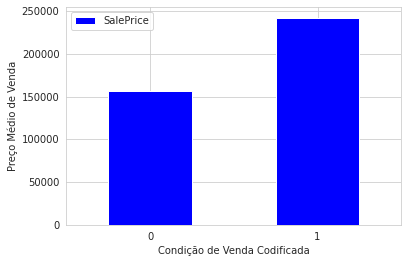

In [ ]:
plt.figure(figsize=(10, 8))

condition_pivot = train.pivot_table(index='enc_condition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')

plt.xlabel('Condição de Venda Codificada')
plt.ylabel('Preço Médio de Venda')
plt.xticks(rotation=0)

plt.show()

###Lidando com dados que faltam

####Antes de criarmos nosso modelo, precisamos lidar de alguma força com informações faltantes em nosso DataFrame. Primeiramente irei analisar quais colunas possuem maior ocorrência de 'missing values' (em porcentagem).

In [ ]:
#Porcentagem de valores ausentes na coluna do dataframe
#Excluir colunas com +50% dos dados NULL
print("\nVALORES AUSENTES:")
print((train.isnull().sum() / train.shape[0]).sort_values(ascending=False))


VALORES AUSENTES:
PoolQC           0.995876
MiscFeature      0.963574
Alley            0.937457
Fence            0.806873
FireplaceQu      0.473540
LotFrontage      0.177320
GarageQual       0.055670
GarageCond       0.055670
GarageType       0.055670
GarageYrBlt      0.055670
GarageFinish     0.055670
BsmtFinType2     0.026117
BsmtExposure     0.026117
BsmtQual         0.025430
BsmtCond         0.025430
BsmtFinType1     0.025430
MasVnrArea       0.005498
MasVnrType       0.005498
Electrical       0.000687
RoofMatl         0.000000
RoofStyle        0.000000
ExterQual        0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
YearBuilt        0.000000
ExterCond        0.000000
Foundation       0.000000
YearRemodAdd     0.000000
enc_condition    0.000000
OverallCond      0.000000
Utilities        0.000000
MSSubClass       0.000000
MSZoning         0.000000
LotArea          0.000000
Street           0.000000
LotShape         0.000000
LandContour      0.000000
LotConfig        0.

####Do conjunto acima, iremos descartar colunas que possuem 'Missing Values' acima ou próximo de 50% do total de seus dados. Também irei lidar com os 'Missing Values' através da função Imputer do sklearn.

In [ ]:
from sklearn.impute import SimpleImputer

#Preparação dos Dados

#Todas as mudanças feitas no conjunto Train devem ser feitas no conjunto Test também.

train_cleanedData = train.copy()
test_cleanedData = test.copy()

# descartar as colunas Id, PoolQC, MiscFeature, Alley, Fence, FireplaceQu, e nosso target SalePrice
#Aqui tbm retiro o target pois usarei isto para criar o novo train e test posteriormente. Nosso target será obtido através de np.lop(train.SalePrice)  
train_cleanedData.drop(labels=['Id', 'PoolQC',
                      'MiscFeature', 'Alley',
                      'Fence', 'FireplaceQu', 'SalePrice'], axis=1, inplace=True)

test_cleanedData.drop(labels=['Id', 'PoolQC',
                      'MiscFeature', 'Alley',
                      'Fence', 'FireplaceQu'], axis=1, inplace=True)

# Valores nulos ao longo das categorias
numNullbefore = train_cleanedData.isnull().sum()
numNullbefore = numNullbefore[ numNullbefore > 0].notnull().sum()
print("Número de colunas com nulos antes da preparação:", numNullbefore)

#Obtendo as colunas numéricas e as categoricas
num_df = train_cleanedData.select_dtypes(exclude='object').columns
cat_df = train_cleanedData.select_dtypes(include='object').columns

num_dfTest = test_cleanedData.select_dtypes(exclude='object').columns
cat_dfTest = test_cleanedData.select_dtypes(include='object').columns

#Limpando valores nulos nas variáveis numéricas
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

  #Limpando o train

imputer = imputer.fit(train_cleanedData.loc[:,num_df])
train_cleanedData.loc[:,num_df] = imputer.transform(train_cleanedData.loc[:,num_df])

  #Limpando o test

imputer = imputer.fit(test_cleanedData.loc[:,num_dfTest])
test_cleanedData.loc[:,num_dfTest] = imputer.transform(test_cleanedData.loc[:,num_dfTest])

#Limpando valores nulos nas variáveis categoricas
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

  #Limpando o train

imputer = imputer.fit(train_cleanedData.loc[:,cat_df])
train_cleanedData.loc[:,cat_df] = imputer.transform(train_cleanedData.loc[:,cat_df])

  #Limpando o test

imputer = imputer.fit(test_cleanedData.loc[:,cat_dfTest])
test_cleanedData.loc[:,cat_dfTest] = imputer.transform(test_cleanedData.loc[:,cat_dfTest])

# Valores nulos ao longo das categorias
numNullafter = train_cleanedData.isnull().sum()
numNullafter = numNullafter[ numNullafter > 0].notnull().sum()
print("Número de colunas com nulos depois da preparação:", numNullafter)


Número de colunas com nulos antes da preparação: 14
Número de colunas com nulos depois da preparação: 0


###Criando o modelo de predição de preços

####Vamos por fim criar nosso modelo de predição de preços. Para isso iremos separar as features desejadas e o nosso 'Target' - Alvo, respectivamente em x e y. Usarei os preços na escala logaritmica, como explicado na análise acima.

In [ ]:
y = np.log(train.SalePrice)
X = train_cleanedData.select_dtypes(include=[np.number])
#Usaremos somente as colunas numéricas e as colunas que foram codificadas para números. O restante dos dados será descartado
#Peguei o DataFrame train_cleanedData pois nele já fizemos a limpeza dos dados faltantes e retiramos também o target.

In [ ]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,enc_street,enc_condition
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,1.0,0.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,1.0,0.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,1.0,0.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,1.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,1.0,0.0


####Vamos agora particionar nossos dados em train e test.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=55, test_size=.33)

Criaremos então nosso modelo. Para esta análise usarei a [Regressão Linear](https://https://en.wikipedia.org/wiki/Linear_regression) como técnica de modelagem deste problema.

In [ ]:
from sklearn import linear_model

lr = linear_model.LinearRegression()

Após criarmos o modelo, é preciso treiná-lo.

In [ ]:
model = lr.fit(X_train, y_train)

###Medindo a performance do nosso modelo

Para validarmos a performance do nosso modelo, seguiremos o padrão do Kaggle e usaremos o método "[Root-mean-squared-error](https://https://en.wikipedia.org/wiki/Root-mean-square_deviation)". Também olharei para o valor de [R^2](https://en.wikipedia.org/wiki/Coefficient_of_determination). Este valor mede o quão próximo os valores estão da linha de aprendizado da regressão.

In [ ]:
print("O valor de R² é de:", model.score(X_test, y_test))

O valor de R² é de: 0.8603617977558645


In [ ]:
predictions = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

print("O valor do RSME é:", mean_squared_error(y_test, predictions))

O valor do RSME é: 0.022212262860333124


####Para facilitar a vizualização, irei plotar o gráfico da regressão linear.

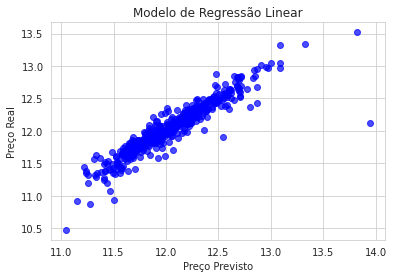

In [ ]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.7, color='b')
plt.xlabel('Preço Previsto')
plt.ylabel('Preço Real')
plt.title('Modelo de Regressão Linear')
plt.show()